In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from skimage import io
from os.path import expanduser
from tqdm import tqdm
HOME = expanduser("~")
import os, sys
import SimpleITK as sitk
import cv2
%load_ext autoreload
%autoreload 2

In [4]:
animal = 'DK63'
DIR = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps'
INPUT = os.path.join(DIR, 'CH1', 'thumbnail_cleaned')
ELASTIX = os.path.join(DIR, 'elastix')
PATH = os.path.join(HOME, 'programming/pipeline_utility')
sys.path.append(PATH)
from src.lib.utilities_registration import register_test, register_simple

In [5]:
fixed_index = str(225).zfill(3)
moving_index = str(226).zfill(3)

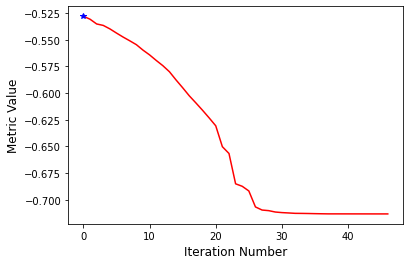

Final metric value: -0.7132642329944574
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Step too small after 47 iterations. Current step (6.10352e-05) is less than minimum step (0.0001).
final (0.02136454597075685, 35.1459461161664, 7.760768082692268)
fixed (870.3303243786136, 552.6018190469305)


In [6]:
test_transform, fixed, moving, R = register_test(INPUT, fixed_index, moving_index)
testParameters = test_transform.GetParameters()
testFixedParameters = test_transform.GetFixedParameters()
# Always check the reason optimization terminated.
stop_condition = R.GetOptimizerStopConditionDescription()
iterations = R.GetOptimizerIteration()
metric_value = R.GetMetricValue()

print(f'Final metric value: {metric_value}')
print(f'Optimizer\'s stopping condition, {stop_condition}')
print('final', testParameters)
print('fixed', testFixedParameters)

In [7]:
R, xshift, yshift = register_simple(INPUT, fixed_index, moving_index)

AttributeError: 'ElastixImageFilter' object has no attribute 'AddCommand'

In [ ]:
width=1703
height=1109
print(width/2)
print(height/2)
img = cv2.imread(os.path.join(INPUT, '200.tif'), -1)
rows = img.shape[0]
cols = img.shape[1]
print(rows/2)
print(cols/2)

In [ ]:
%%time
files = sorted(os.listdir(INPUT))
img = cv2.imread(os.path.join(INPUT, files[0]), -1)
midx = img.shape[1] / 2
midy = img.shape[0] / 2

for f in tqdm(range(len(files) - 1)):
    fixed_index = str(f).zfill(3)
    moving_index = str(f+1).zfill(3)
    outdir = os.path.join(ELASTIX, f'{moving_index}_to_{fixed_index}')
    os.makedirs(outdir, exist_ok=True)
    outfile = os.path.join(outdir, 'TransformParameters.0.txt')
    
    if os.path.exists(outfile):
        continue
    
    R, xshift, yshift = register_simple(INPUT, fixed_index, moving_index)

    f = open(outfile, "a")
    f.write(f"(TransformParameters {R} {xshift} {yshift})\n")
    f.write(f"(CenterOfRotationPoint {midx} {midy})\n")
    f.write("(Spacing 1.0 1.0)\n")
    f.close()


In [ ]:
%%time
pixelType = sitk.sitkFloat32
fixed_file = os.path.join(INPUT, f'{fixed_index}.tif')
moving_file = os.path.join(INPUT, f'{moving_index}.tif')
fixed = sitk.ReadImage(fixed_file, pixelType)
moving = sitk.ReadImage(moving_file, pixelType)

elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(fixed)
elastixImageFilter.SetMovingImage(moving)
elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("rigid"))
translation_params = elastixImageFilter.GetDefaultParameterMap('translation')
translation_params['MaximumNumberOfIterations']=['100']
elastixImageFilter.AddParameterMap(translation_params)
elastixImageFilter.Execute()
r, xshift, yshift = elastixImageFilter.GetTransformParameterMap()[0]["TransformParameters"]
print(r)
print(xshift)
print(yshift)

In [ ]:
moving_resampled = sitk.Resample(moving, fixed, final_transform, sitk.sitkLinear, 0.0, moving.GetPixelID())
fig = plt.figure(figsize=(15,8))
plt.imshow(sitk.GetArrayViewFromImage(fixed), cmap='gray')
plt.grid()
plt.title('fixed image', fontsize=10)

fig = plt.figure(figsize=(15, 8))
plt.imshow(sitk.GetArrayViewFromImage(moving_resampled), cmap='gray')
plt.grid()
plt.title('resampled image')

fig = plt.figure(figsize=(15, 8))
plt.title('moving image')
plt.grid()
plt.imshow(sitk.GetArrayViewFromImage(moving), cmap='gray')
    

In [ ]:
#geometry Final metric value: -0.3050850951798145
#Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Step too small after 69 iterations. Current step (6.10352e-05) is less than minimum step (0.0001).
#rotation, xshift, yshift (0.002372645049694355, 1.06484770727788, -29.715144692551913)

#moments Final metric value: -0.31838088083076627
#Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Maximum number of iterations (80) exceeded.
#rotation, xshift, yshift (-0.0034537801668540033, -28.17482735969523, -45.74971520579796)

#moments, with no Setoptscales Final metric value: -0.31014666630255233
#Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Step too small after 26 iterations. .
#rotation, xshift, yshift (-0.06870509561607951, -4.210244784366168, -35.41774791170732)

# means square
#rotation, xshift, yshift (-0.004593785628556457, -28.54399266359482, -45.8018880776268)

#simialarity Final metric value: -0.3653938756091227
#Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Maximum number of iterations (80) exceeded.
#rotation, xshift, yshift (0.9354990407253294, 0.006315032681630877, -47.83047698059379, -41.41794215960105)

In [ ]:
0.9354990407253294 * 0.006315032681630877